In [82]:
# inline plotting
%matplotlib inline

# allow live package editing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing the OpenDSM library

Once the OpenDSM has been installed, it can be imported as shown below.

This tutorial requires OpenDSM version > 1.2.x. Verify the version you have installed.

We will load eemeter and drmeter modules separately

In [83]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import (
    eemeter as em,
    drmeter as dm,
)

print(f"OpenDSM {odsm.__version__}")

OpenDSM 1.2.6


## Loading data

The essential inputs to OpenDSM library functions are the following:

1. Meter baseline data named `observed`
2. Meter reporting data `observed`
3. Temperature data from a nearby weather station for both named `temperature`
4. All data is expected to have a timezone-aware datetime index or column named `datetime`

Users of the library are responsible for obtaining and formatting this data (to get weather data, see [eeweather](https://eeweather.openee.io/), which helps perform site to weather station matching and can pull and cache temperature data directly from public (US) data sources). Some samples come loaded with the library and we'll load these first to save you the trouble of loading in your own data.

We utilize data classes to store meter data, perform transforms, and validate the data to ensure data compliance. The inputs into these data classes can either be [pandas](https://pandas.pydata.org/) `DataFrame` if initializing the classes directly or `Series` if initializing the classes using `.from_series`.

The test data contained within the OpenDSM library is derived from [NREL ComStock](https://comstock.nrel.gov/) simulations.

If working with your own data instead of these samples, please refer directly to the excellent pandas documentation for instructions for loading data (e.g., [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)).

### Important notes about data:
- *These models were developed and tested using Fahrenheit temperature. Please convert your temperatures accordingly*
- *It is expected that all data is trimmed to its appropriate time period (baseline and reporting) and does not contain extraneous datetimes*
- *If you run load_test_data it will download the necessary files from the OpenDSM repository. This can be up to 150 MB*

In [84]:
# Load in test data
#     - This data contains 100 different meters

df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [85]:
print(df_baseline)

                                  temperature    observed
id     datetime                                          
110596 2018-01-01 00:00:00-06:00     3.320000  144.403058
       2018-01-01 01:00:00-06:00     2.240000  195.924520
       2018-01-01 02:00:00-06:00     1.040000  204.974650
       2018-01-01 03:00:00-06:00    -0.100000  205.451629
       2018-01-01 04:00:00-06:00    -1.300000  207.125299
...                                       ...         ...
109141 2018-12-31 19:00:00-06:00    36.735385  391.010745
       2018-12-31 20:00:00-06:00    35.285000  227.541210
       2018-12-31 21:00:00-06:00    35.558462   71.686047
       2018-12-31 22:00:00-06:00    35.558462   37.559550
       2018-12-31 23:00:00-06:00    35.651429   11.853843

[876000 rows x 2 columns]


In [86]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.HourlyBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.HourlyReportingData(df_reporting_n, is_electricity_data=True)

hourly_model = em.HourlyModel().fit(baseline_data, ignore_disqualification=False)
hourly_model.predict(baseline_data).head()

{'n_extreme_values': 2, 'median': 7.244165859677629, 'upper_quantile': 12.55184370957716, 'lower_quantile': 3.5384346926350125, 'lower_bound': -23.501792358191427, 'upper_bound': 39.5920707604036, 'min_value': 0.487812107473959, 'max_value': 40.06490295571486}
{'n_extreme_values': 2, 'median': 7.244165859677629, 'upper_quantile': 12.55184370957716, 'lower_quantile': 3.5384346926350125, 'lower_bound': -23.501792358191427, 'upper_bound': 39.5920707604036, 'min_value': 0.487812107473959, 'max_value': 40.06490295571486}


,temperature,observed,date,hour_of_day,interpolated_temperature,interpolated_observed,has_pv,predicted,predicted_unc
2018-01-01 00:00:00-06:00,-5.08,30.336523,2018-01-01,0,False,False,1,28.641114,1.452375
2018-01-01 01:00:00-06:00,-5.98,37.355408,2018-01-01,1,False,False,1,31.911000,1.452375
2018-01-01 02:00:00-06:00,-7.06,39.376695,2018-01-01,2,False,False,1,33.181979,1.452375
2018-01-01 03:00:00-06:00,-7.06,39.911217,2018-01-01,3,False,False,1,33.994147,1.452375
2018-01-01 04:00:00-06:00,-7.06,39.406699,2018-01-01,4,False,False,1,33.966934,1.452375


In [87]:
print(df_baseline_n)

                           temperature   observed
datetime                                         
2018-01-01 00:00:00-06:00        -5.08  30.336523
2018-01-01 01:00:00-06:00        -5.98  37.355408
2018-01-01 02:00:00-06:00        -7.06  39.376695
2018-01-01 03:00:00-06:00        -7.06  39.911217
2018-01-01 04:00:00-06:00        -7.06  39.406699
...                                ...        ...
2018-12-31 19:00:00-06:00        33.98  15.388135
2018-12-31 20:00:00-06:00        33.98  15.261147
2018-12-31 21:00:00-06:00        33.98  13.970028
2018-12-31 22:00:00-06:00        33.92  14.095850
2018-12-31 23:00:00-06:00        33.98   3.519598

[8760 rows x 2 columns]


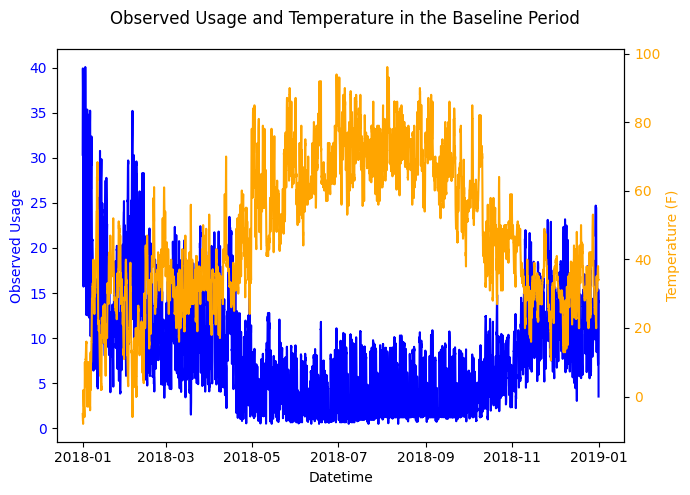

In [88]:
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Observed Usage', color=color)
ax1.plot(df_baseline_n.index, df_baseline_n['observed'], label='Observed Usage', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'orange'
ax2.set_ylabel('Temperature (F)', color=color)
ax2.plot(df_baseline_n.index, df_baseline_n['temperature'], label='Temperature (F)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Observed Usage and Temperature in the Baseline Period')
fig.tight_layout()
plt.show()

In [89]:
print(baseline_data.df)

                           temperature   observed        date  hour_of_day  \
2018-01-01 00:00:00-06:00        -5.08  30.336523  2018-01-01            0   
2018-01-01 01:00:00-06:00        -5.98  37.355408  2018-01-01            1   
2018-01-01 02:00:00-06:00        -7.06  39.376695  2018-01-01            2   
2018-01-01 03:00:00-06:00        -7.06  39.911217  2018-01-01            3   
2018-01-01 04:00:00-06:00        -7.06  39.406699  2018-01-01            4   
...                                ...        ...         ...          ...   
2018-12-31 19:00:00-06:00        33.98  15.388135  2018-12-31           19   
2018-12-31 20:00:00-06:00        33.98  15.261147  2018-12-31           20   
2018-12-31 21:00:00-06:00        33.98  13.970028  2018-12-31           21   
2018-12-31 22:00:00-06:00        33.92  14.095850  2018-12-31           22   
2018-12-31 23:00:00-06:00        33.98   3.519598  2018-12-31           23   

                           interpolated_temperature  interpolat

In [90]:
# baseline_data = em.BillingBaselineData.from_series(df_baseline_n['observed'], df_baseline_n['temperature'], is_electricity_data=True)

In [91]:
print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.extreme_values_detected)]


In [92]:
hourly_model.plot(baseline_data)

NotImplementedError: 

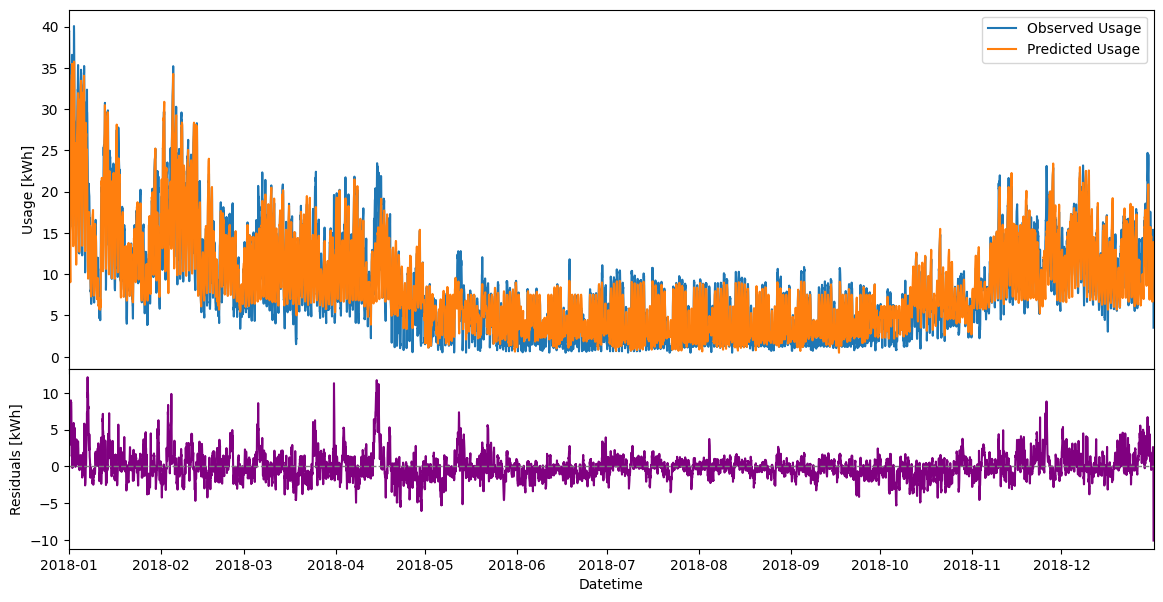

In [107]:
df_results = hourly_model.predict(baseline_data)

# Decimate data: plot every 24th point (i.e., daily for hourly data)
decimation_factor = 1
df_results_decimated = df_results.iloc[::decimation_factor, :]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: Observed and Predicted Usage
ax1.plot(df_results_decimated.index, df_results_decimated['observed'], label='Observed Usage')
ax1.plot(df_results_decimated.index, df_results_decimated['predicted'], label='Predicted Usage')
ax1.set_ylabel('Usage [kWh]')
ax1.legend()

# Lower panel: Residuals
residuals_decimated = df_results_decimated['observed'] - df_results_decimated['predicted']
ax2.plot(df_results_decimated.index, residuals_decimated, color='purple', label='Residuals (Observed - Predicted)')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel('Datetime')
ax2.set_ylabel('Residuals [kWh]')

ax1.set_xlim(df_results_decimated.index.min(), df_results_decimated.index.max())
ax2.set_xlim(df_results_decimated.index.min(), df_results_decimated.index.max())

fig.subplots_adjust(hspace=0)

plt.show()

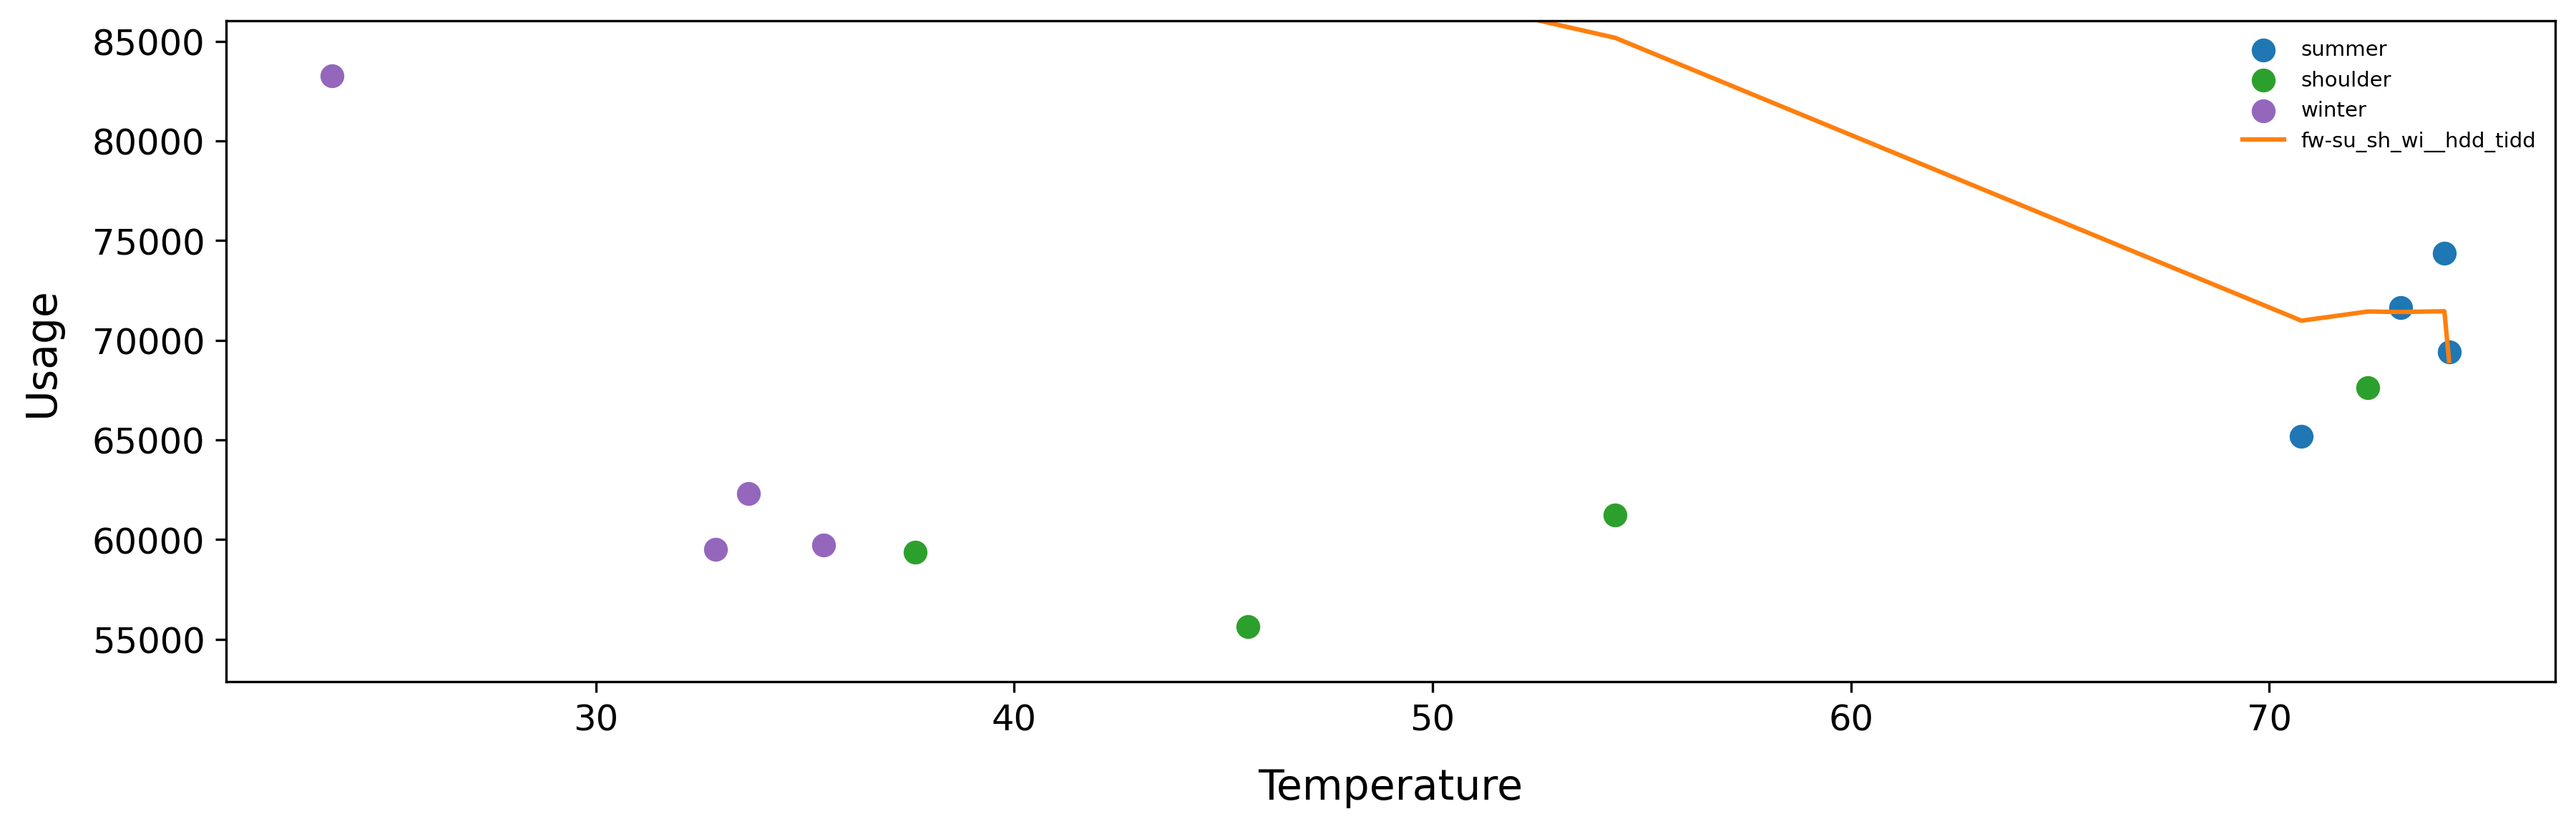

In [ ]:
hourly_model.plot(reporting_data)

In [67]:
df_results = hourly_model.predict(reporting_data)
print(df_results.head())

                           temperature   observed        date  hour_of_day  \
2019-01-01 00:00:00-06:00        -5.08  23.181797  2019-01-01            0   
2019-01-01 01:00:00-06:00        -5.98  29.068728  2019-01-01            1   
2019-01-01 02:00:00-06:00        -7.06  30.883118  2019-01-01            2   
2019-01-01 03:00:00-06:00        -7.06  31.304552  2019-01-01            3   
2019-01-01 04:00:00-06:00        -7.06  30.778175  2019-01-01            4   

                           interpolated_temperature  interpolated_observed  \
2019-01-01 00:00:00-06:00                     False                  False   
2019-01-01 01:00:00-06:00                     False                  False   
2019-01-01 02:00:00-06:00                     False                  False   
2019-01-01 03:00:00-06:00                     False                  False   
2019-01-01 04:00:00-06:00                     False                  False   

                           has_pv  predicted  predicted_unc  


In [68]:
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

Predicted Usage (kWh):  76326.75
Observed Usage (kWh):   58782.37
Savings (kWh):          17544.38


In [69]:
saved_model = hourly_model.to_json()
print(saved_model)

{"settings": {"train_features": ["temperature"], "cvrmse_threshold": 1.4, "pnrmse_threshold": 2.2, "min_daily_training_hours": 12, "temperature_bin": {"method": "fixed_bins", "n_bins": null, "bin_width": 25, "fixed_bins": [10, 30, 50, 65, 75, 90, 105], "min_bin_count": 20, "include_edge_bins": true, "edge_bin_rate": "heuristic", "edge_bin_percent": null, "edge_bin_temperature_range_offset": 1.0}, "temporal_cluster": {"standardize": true, "transform_settings": {"wavelet_n_levels": 4, "wavelet_name": "db1", "wavelet_mode": "smooth", "pca_method": "pca", "pca_min_variance_ratio_explained": null, "pca_n_components": "mle", "pca_include_median": true}, "algorithm_selection": "spectral", "bisecting_kmeans": null, "birch": null, "dbscan": null, "hdbscan": null, "spectral": {"eigen_solver": "arpack", "n_components": null, "affinity": "rbf", "nearest_neighbors": 5, "gamma": 1.05, "eigen_tol": "auto", "assign_labels": "cluster_qr", "n_cluster": {"lower": 2, "upper": 24}, "scoring": {"min_cluster

In [70]:
loaded_model = em.HourlyModel.from_json(saved_model)

In [76]:
# set rows 1:380 of observed to nan
df_baseline_n_dq = df_baseline_n.copy()
df_baseline_n_dq.loc[df_baseline_n_dq.index[1:76], "observed"] = np.nan

baseline_data_DQ = em.HourlyBaselineData(df_baseline_n_dq, is_electricity_data=True)
print(f"Disqualifications: {baseline_data_DQ.disqualification}")

{'lowest_monthly_coverage': 0.8991935483870968}


Disqualifications: [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.missing_monthly_observed_data)]


In [78]:
try:
    hourly_model = em.HourlyModel().fit(baseline_data_DQ)
except Exception as e:
    print(f"Exception: {e}")

{'lowest_monthly_coverage': 0.8991935483870968}


Exception: Can't fit model on disqualified baseline data


In [79]:
hourly_model = em.HourlyModel().fit(baseline_data_DQ, ignore_disqualification=True)

{'lowest_monthly_coverage': 0.8991935483870968}


## Full Example

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.unable_to_confirm_daily_temperature_sufficiency)]


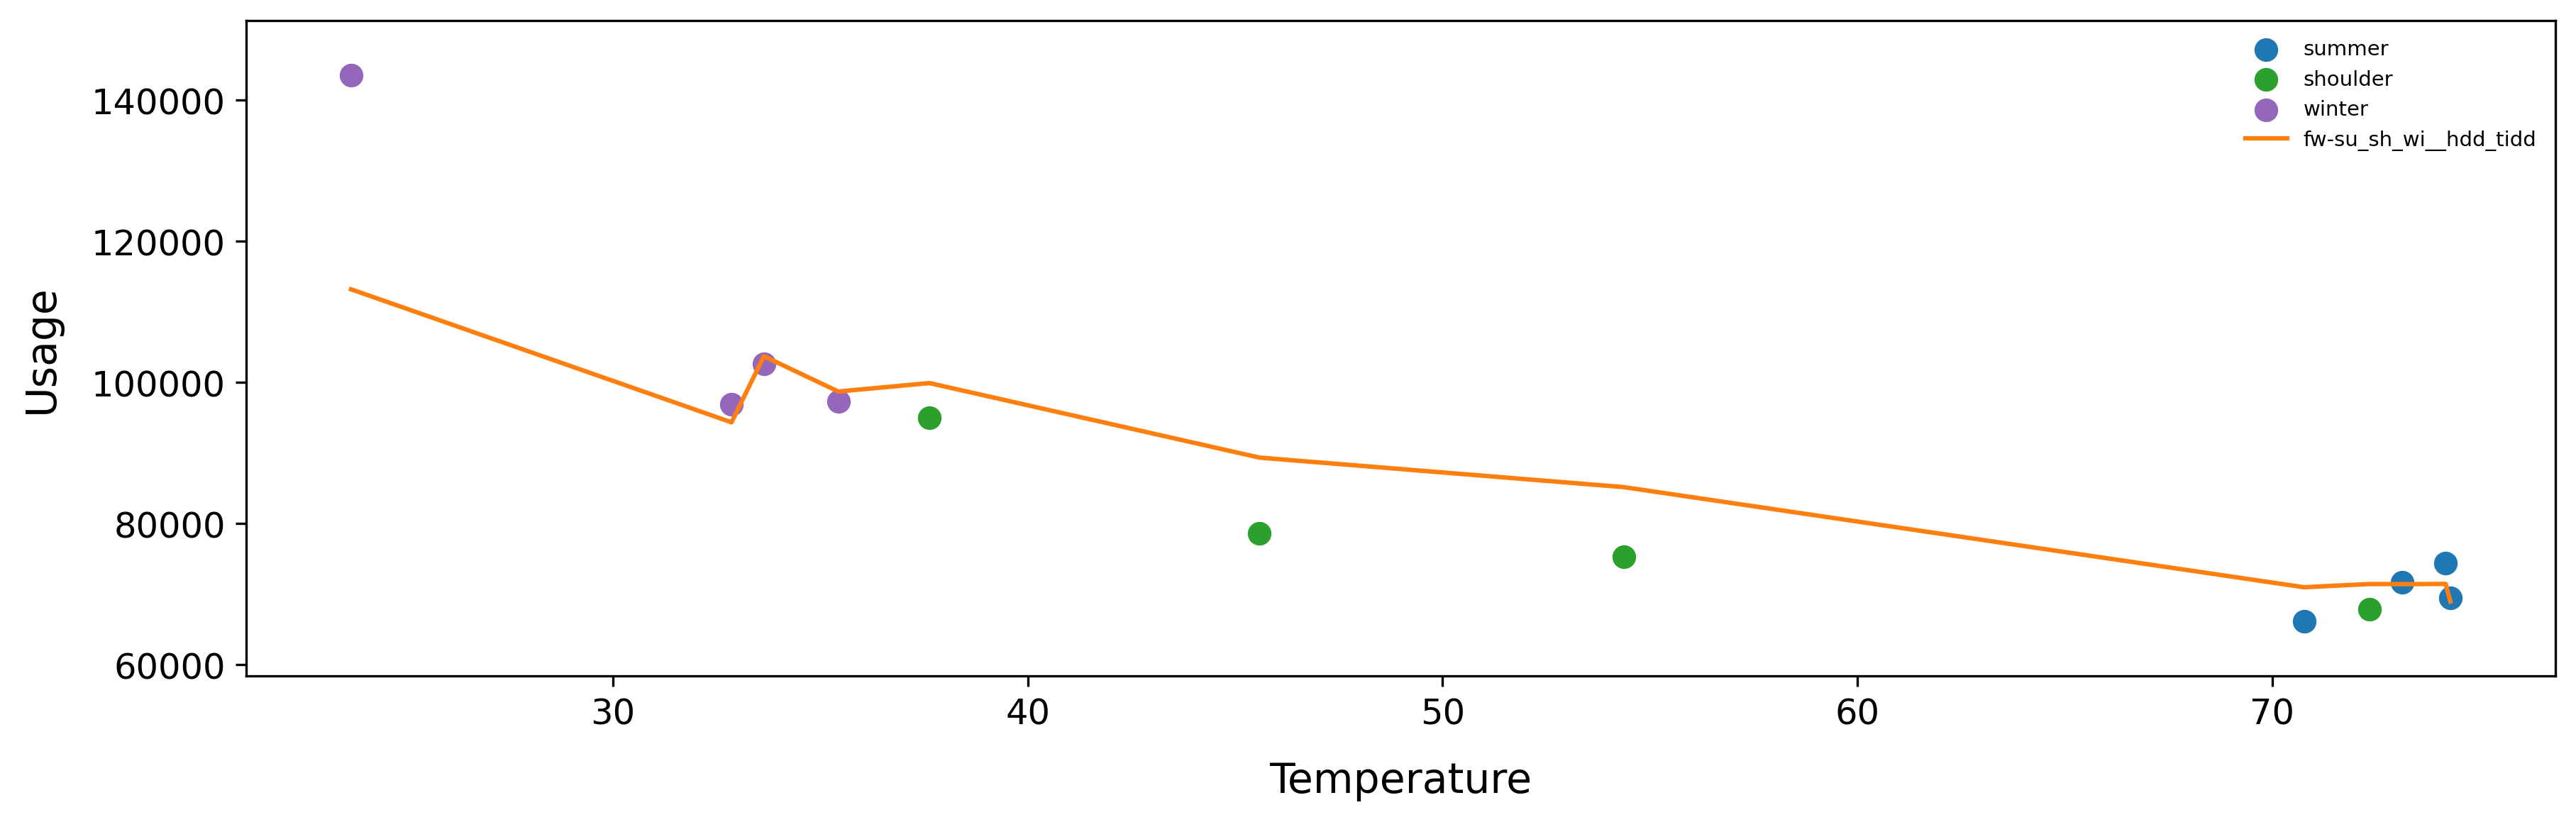

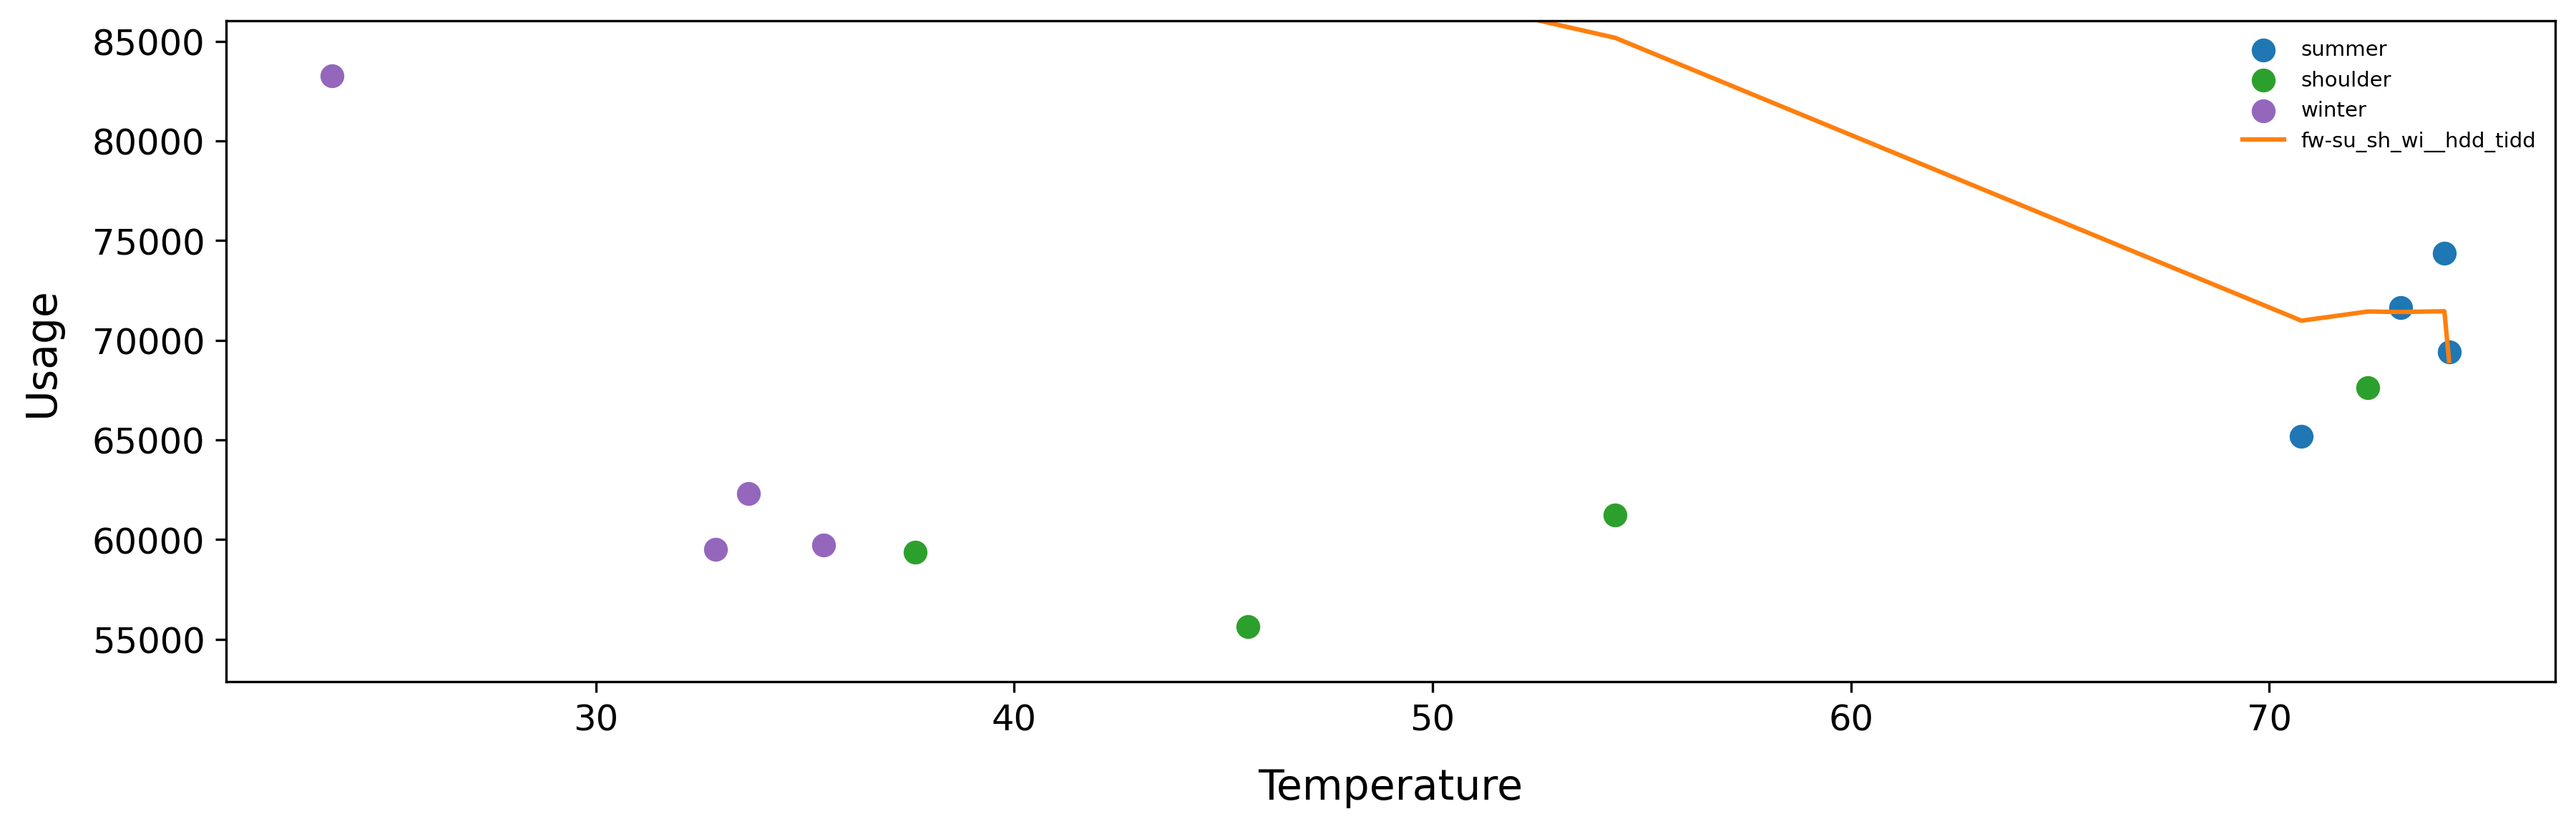

Predicted Usage (kWh):  1038677.49
Observed Usage (kWh):   789252.05
Savings (kWh):          249425.45


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import eemeter as em

df_baseline, df_reporting =  odsm.test_data.load_test_data("monthly_treatment_data")

n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.BillingBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.BillingReportingData(df_reporting_n, is_electricity_data=True)

print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

hourly_model = em.BillingModel()
hourly_model.fit(baseline_data)

# Save model to json
saved_model = hourly_model.to_json()
loaded_model = em.BillingModel.from_json(saved_model)

# Model results
hourly_model.plot(baseline_data, aggregation="monthly")
hourly_model.plot(reporting_data, aggregation="monthly")

df_results = hourly_model.predict(reporting_data, aggregation="monthly")
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

Similarly, the plot function also has the ability to aggregate to `monthly` or `bimonthly`. 

This model is still at its core, a modified daily model though. This is why the model prediction is not straight for either of the aggregations.

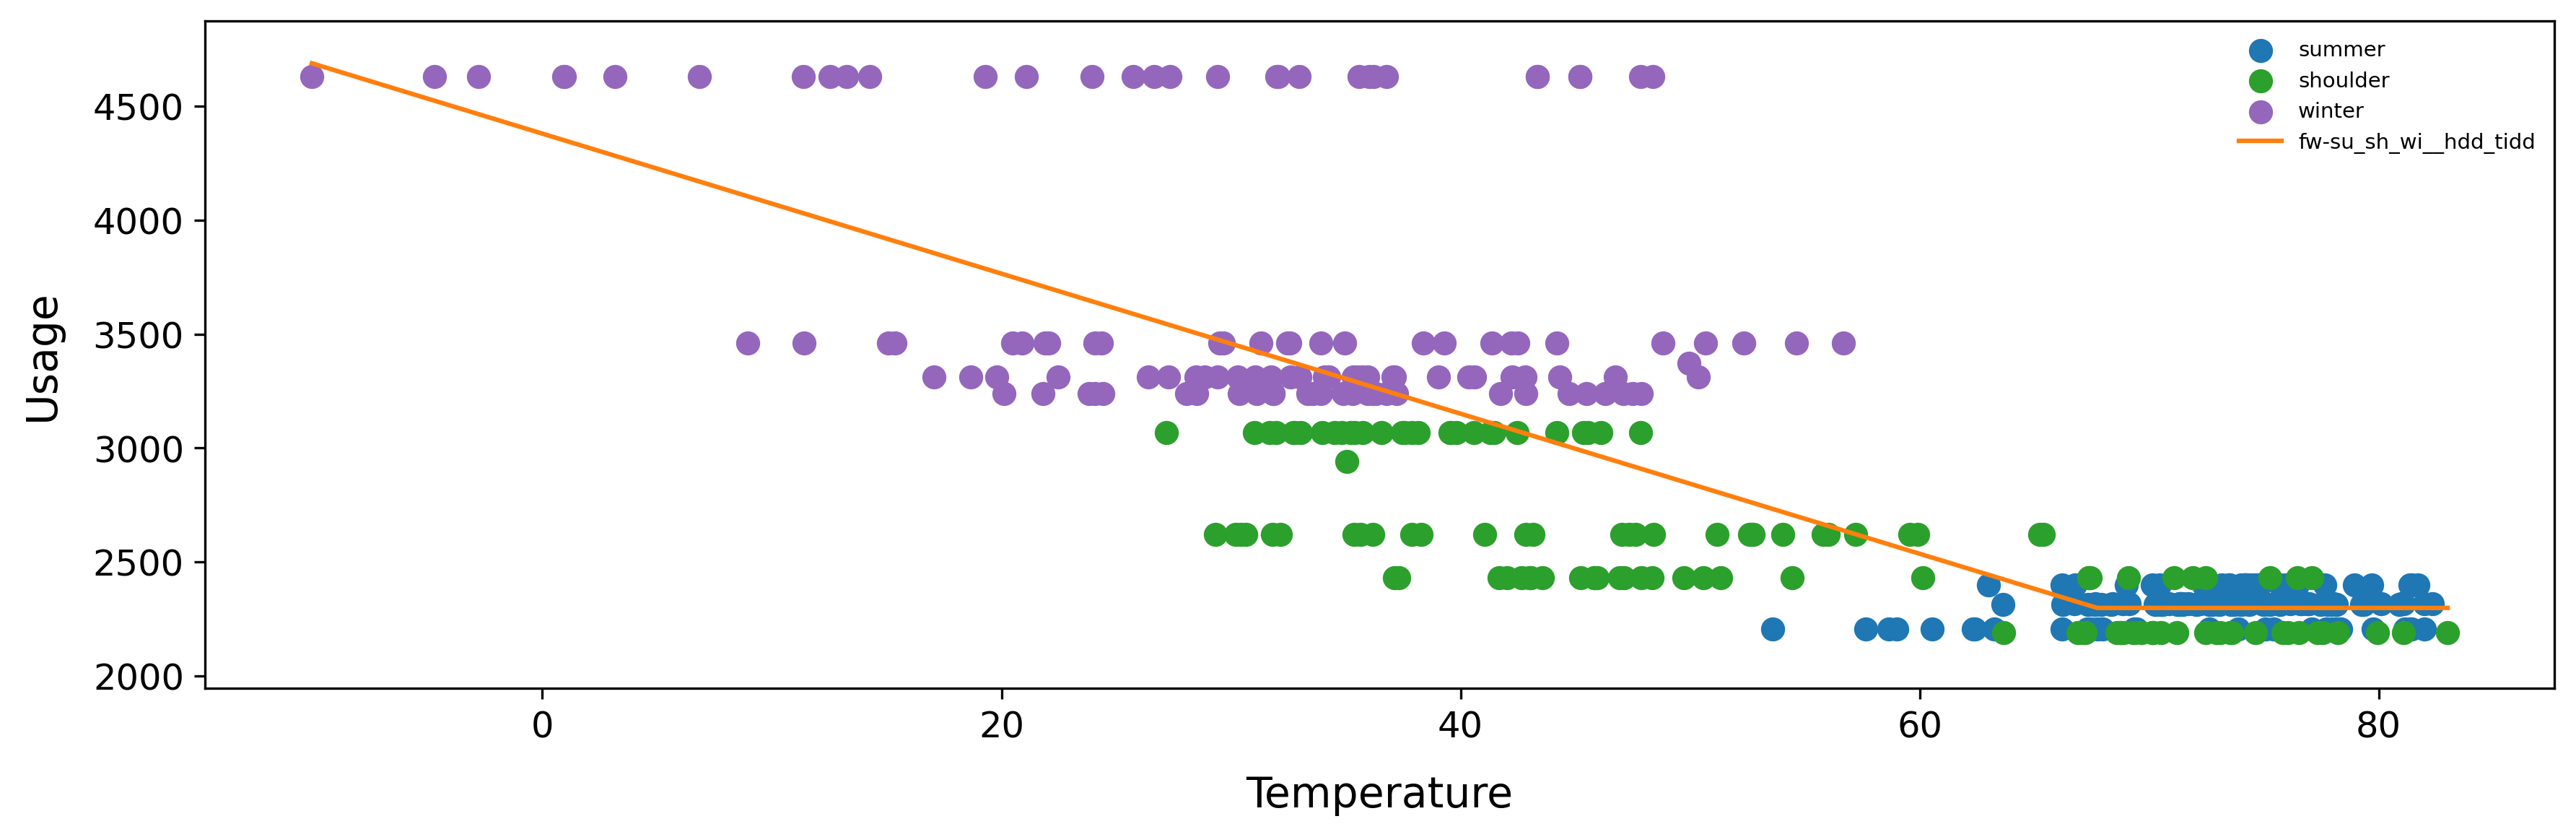

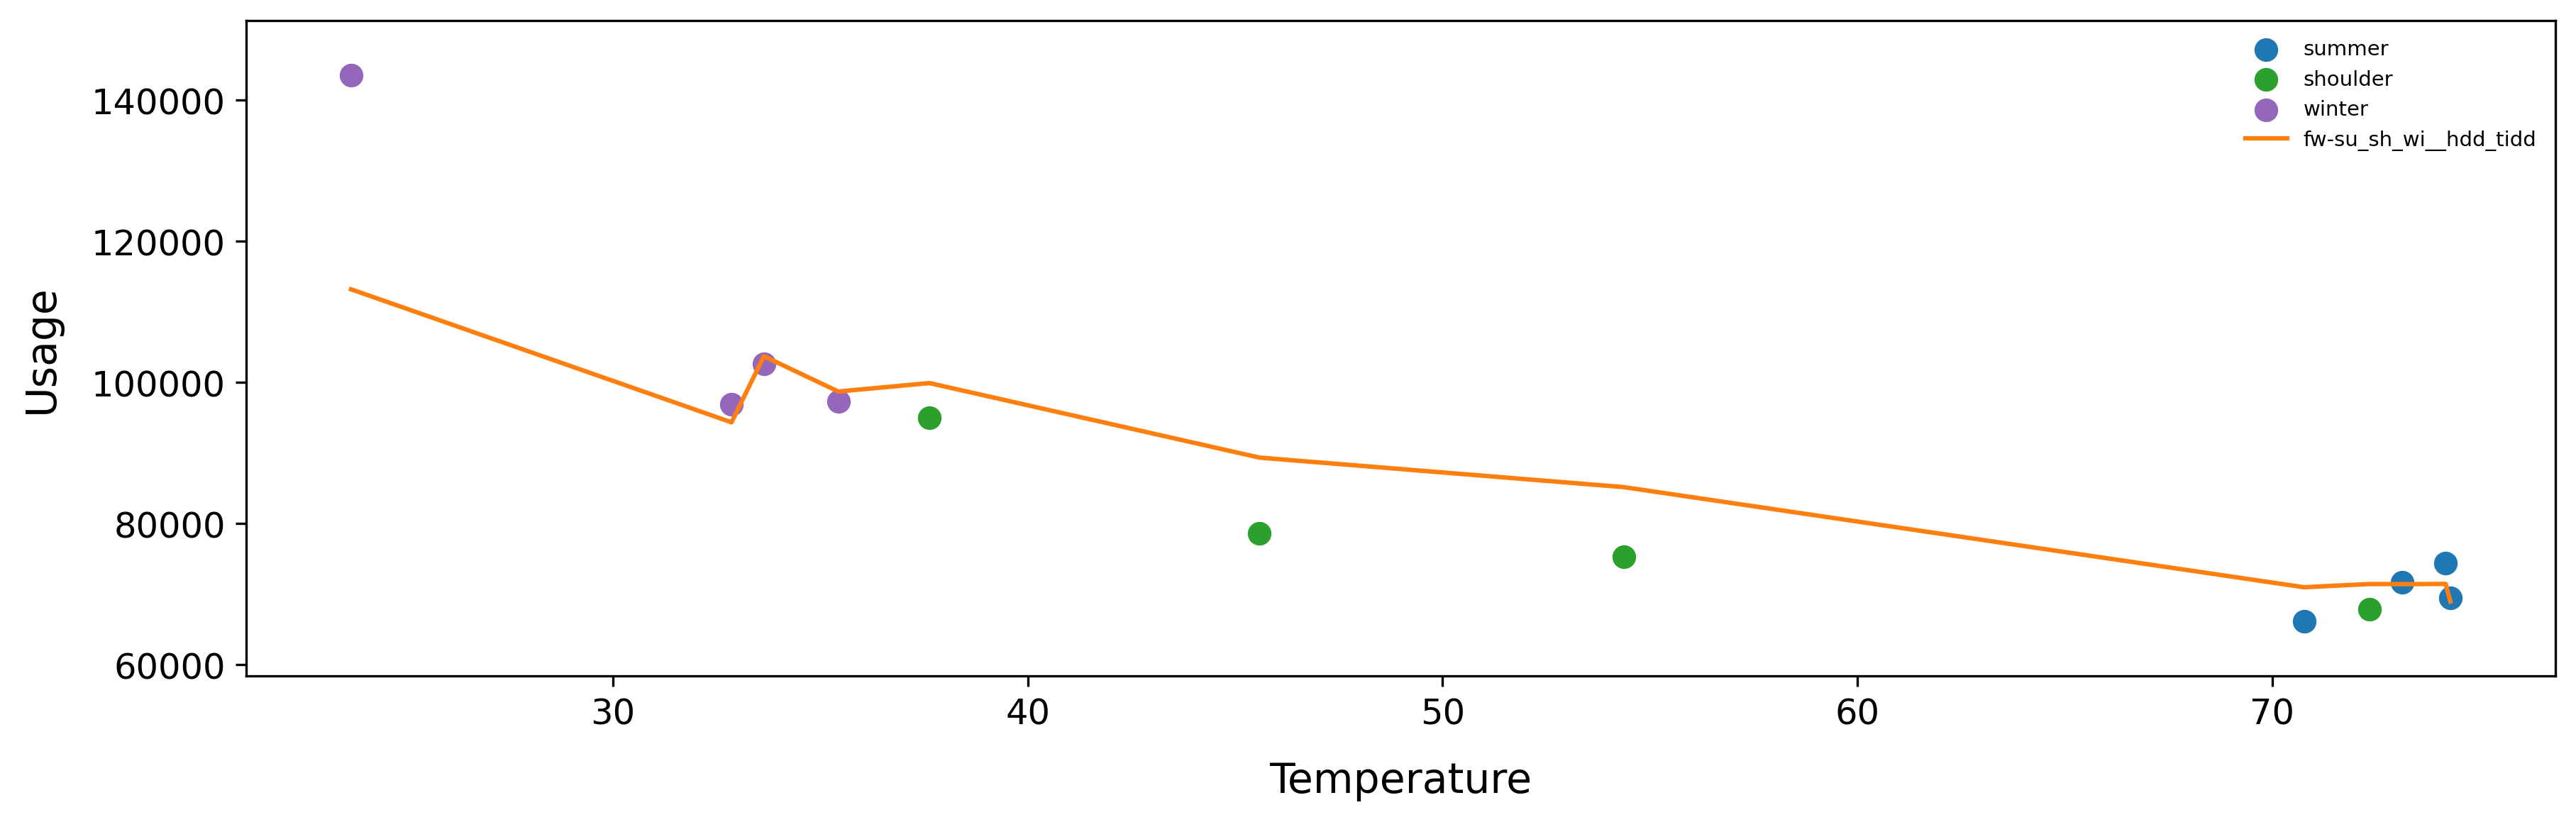

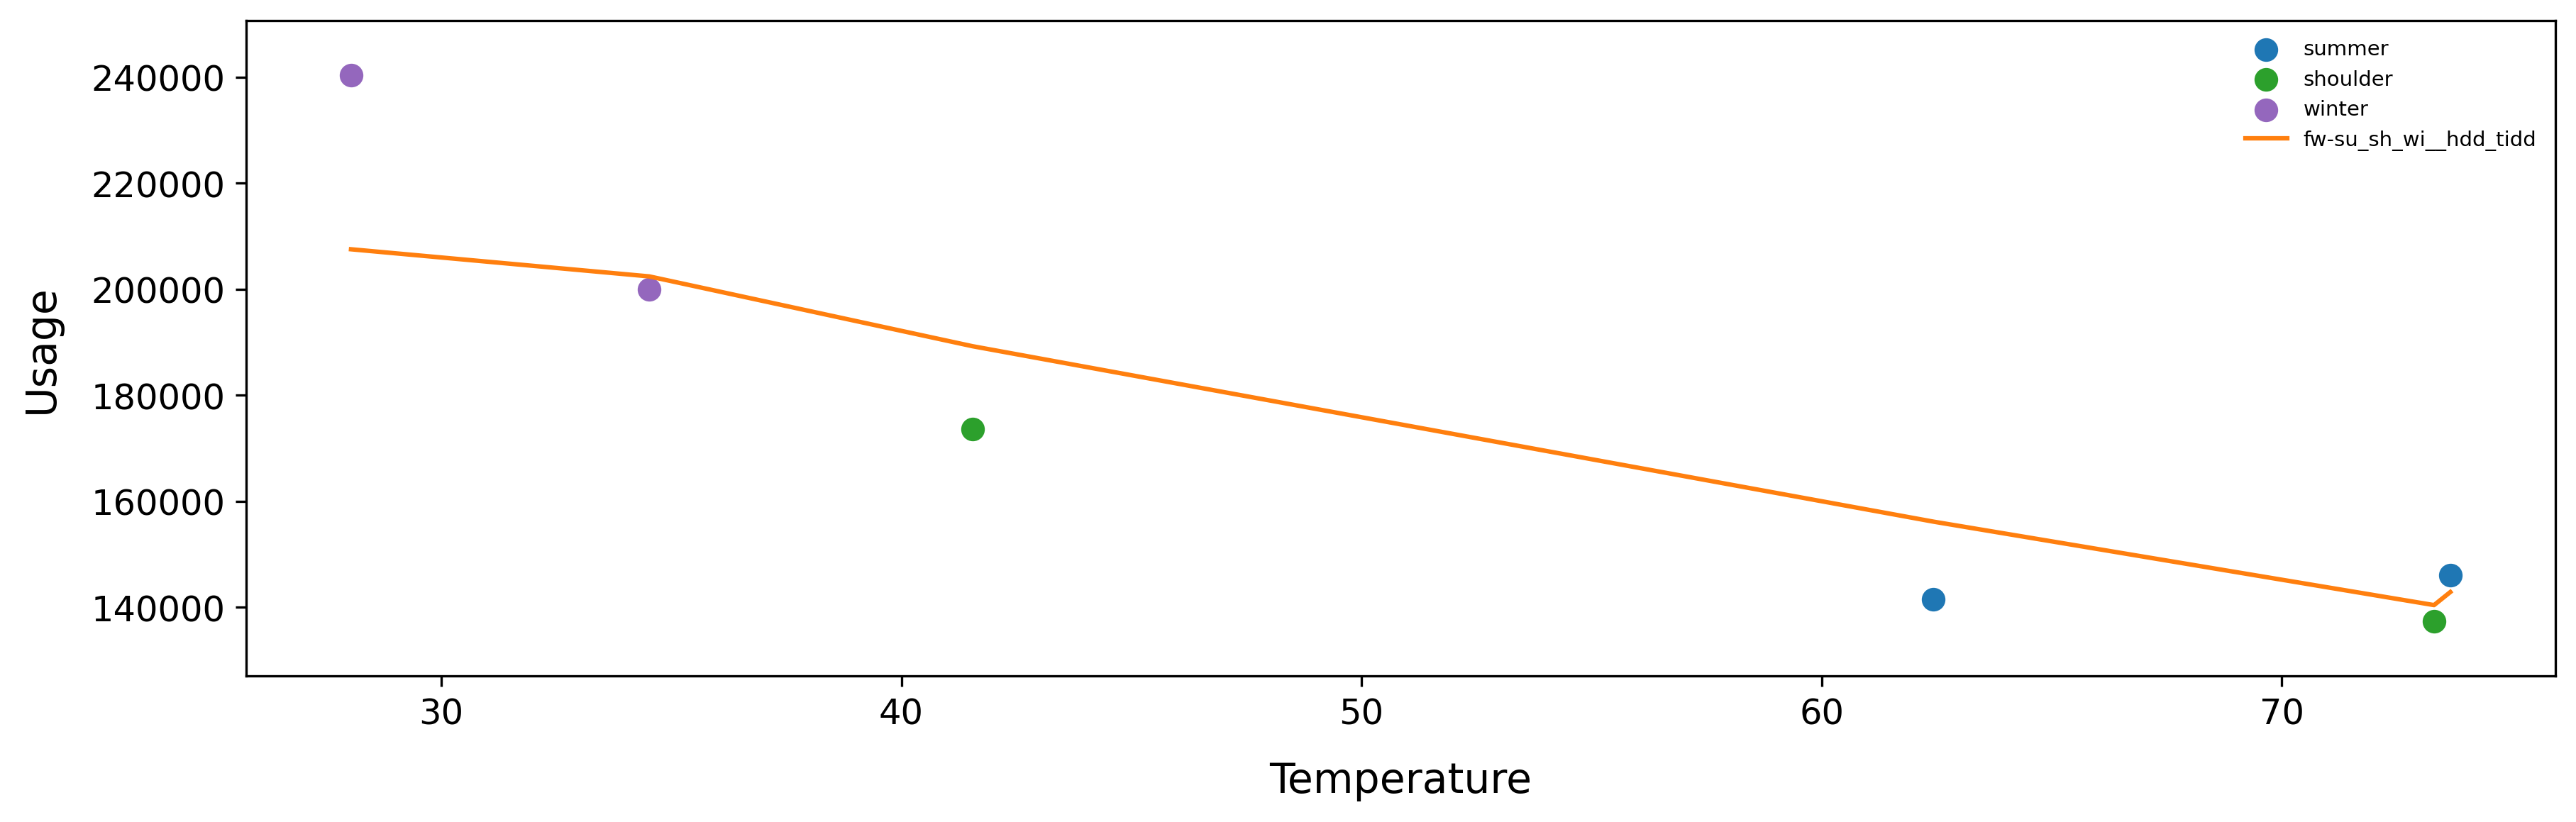

In [ ]:
hourly_model.plot(baseline_data)

hourly_model.plot(baseline_data, aggregation="monthly")

hourly_model.plot(baseline_data, aggregation="bimonthly")

## HOURLY Energy Efficiency Model

Just like the daily and billing model, we follow the same calls but for new data classes and model.

In [ ]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [ ]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

hourly_baseline_data = em.HourlyBaselineData(df_baseline_n, is_electricity_data=True)
hourly_reporting_data = em.HourlyReportingData(df_reporting_n[["temperature"]], is_electricity_data=True)

hourly_model = em.HourlyModel().fit(hourly_baseline_data)

In [ ]:
hourly_model.predict(hourly_baseline_data)

## Hourly Demand Response Model

Finally, we have a demand response model meant to be used for measuring short-term demand response events within `drmeter`, but it too follows the same API structure

In [4]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [6]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

hourly_baseline_data = dm.CaltrackDRBaselineData(df_baseline_n, is_electricity_data=True)
hourly_reporting_data = dm.CaltrackDRReportingData(df_reporting_n[["temperature"]], is_electricity_data=True)

dr_model = dm.CaltrackDRModel().fit(hourly_baseline_data)

/app/applied_data_science/opendsm/opendsm/eemeter/models/hourly_caltrack/data.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["observed"] == 0, "observed"] = np.nan


In [7]:
dr_model.predict(hourly_baseline_data)

,temperature,observed,predicted,predicted_uncertainty
datetime,,,,
2018-01-01 00:00:00-06:00,-5.08,30.336523,31.670276,29.326114
2018-01-01 01:00:00-06:00,-5.98,37.355408,32.070312,29.326114
2018-01-01 02:00:00-06:00,-7.06,39.376695,32.714753,29.326114
2018-01-01 03:00:00-06:00,-7.06,39.911217,32.758016,29.326114
2018-01-01 04:00:00-06:00,-7.06,39.406699,32.789302,29.326114
...,...,...,...,...
2018-12-31 19:00:00-06:00,33.98,15.388135,11.477984,29.326114
2018-12-31 20:00:00-06:00,33.98,15.261147,12.202178,29.326114
2018-12-31 21:00:00-06:00,33.98,13.970028,12.383450,29.326114


## How to calculate savings or avoided energy use

Savings calculation functions are not provided in `eemeter`, but to calculate basic savings is a summation of the subtraction of reporting year observed from baseline year prediction for 1 year.

- Savings = sum(predicted_baseline - observed_reporting)

In [53]:
from PIL import Image

# Load the image
img_path = "/app/applied_data_science/opendsm-website/src/assets/images/eemeter/hourly_model/temperature_bins.png"
img = Image.open(img_path).convert("RGBA")

# Create a white background image
white_bg = Image.new("RGBA", img.size, (255, 255, 255, 255))

# Composite the original image onto the white background
composited = Image.alpha_composite(white_bg, img)

# Convert back to RGB (no alpha) and save, overwriting the original
composited.convert("RGB").save(img_path)

print(f"Image at {img_path} has been updated to have a white background.")


Image at /app/applied_data_science/opendsm-website/src/assets/images/eemeter/hourly_model/temperature_bins.png has been updated to have a white background.


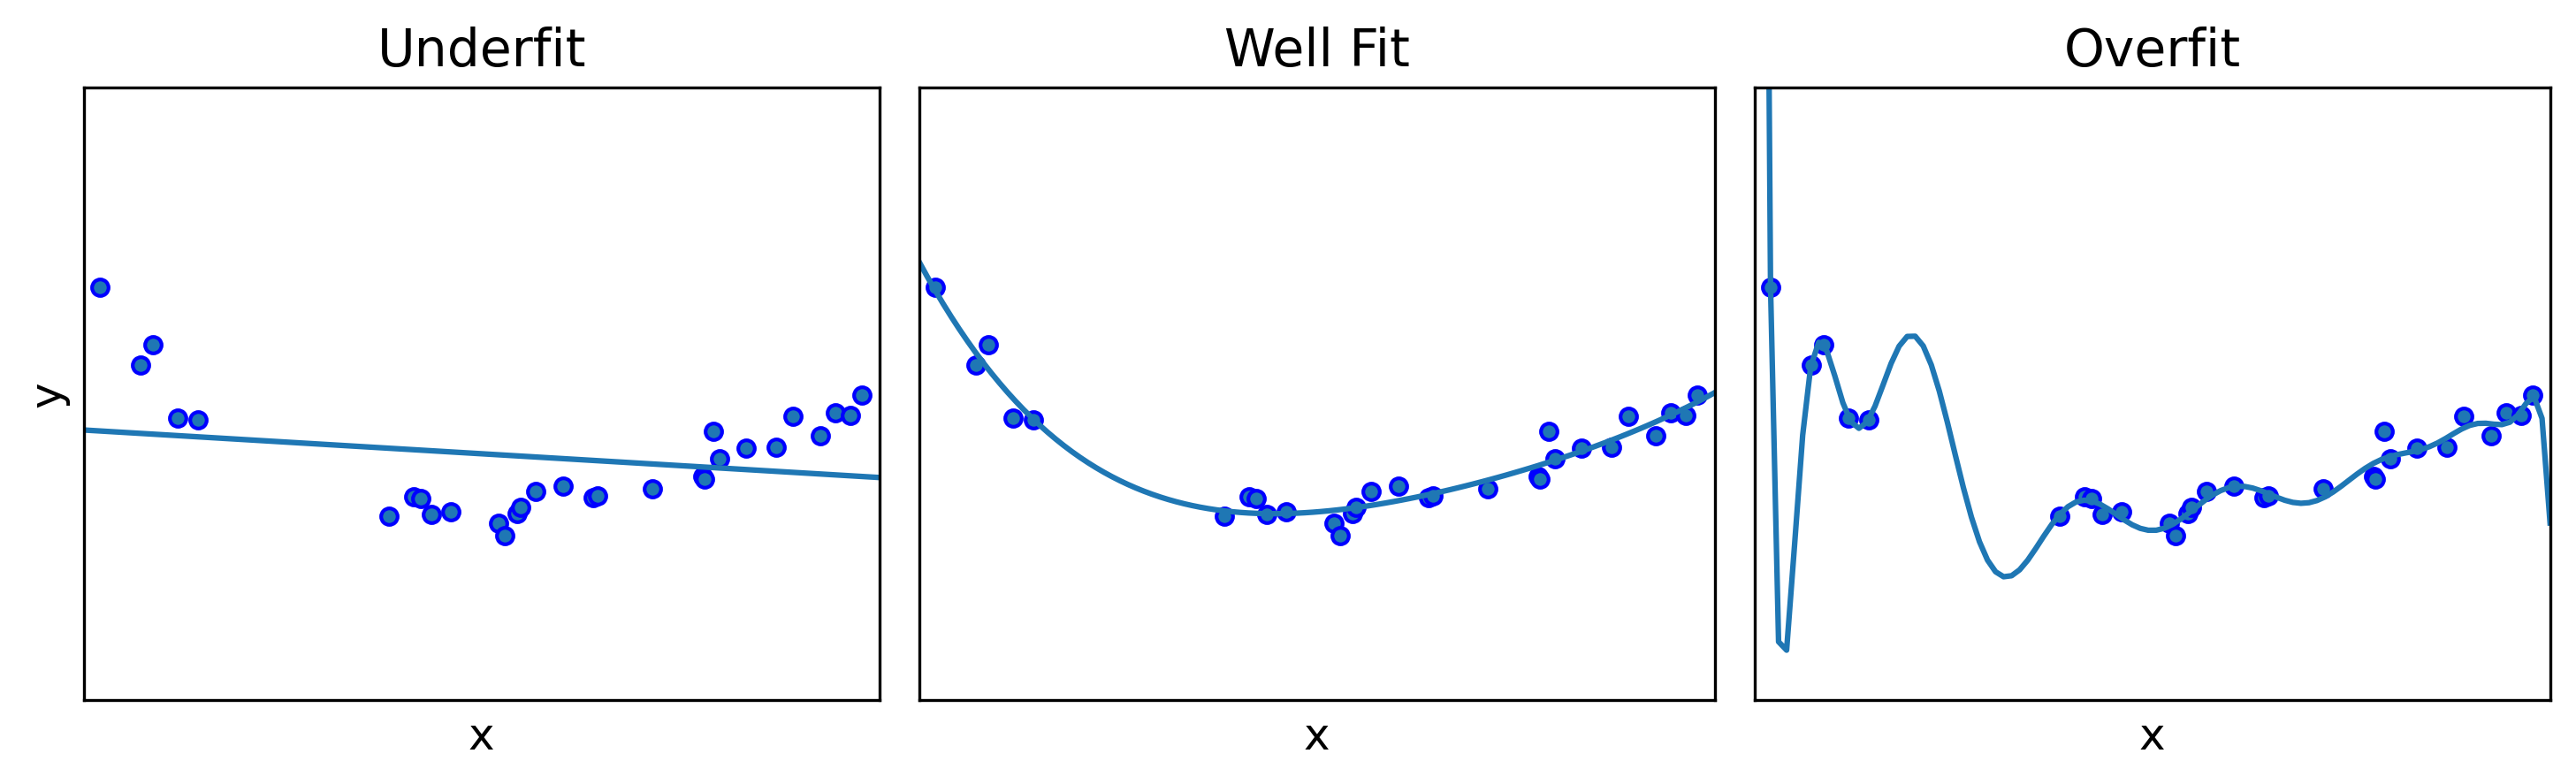

In [52]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X**0.5)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

title = ["Underfit", "Well Fit", "Overfit"]

plt.figure(figsize=(12, 3), dpi=300)
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    # plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x", fontsize=12)
    if i == 0:
        plt.ylabel("y", fontsize=12)
    plt.xlim((0, 1))
    plt.ylim((-2.5, 2.5))
    # plt.legend(loc="best")
    plt.title(title[i], fontsize=14)
    
plt.subplots_adjust(wspace=0.05)
plt.show()